In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Parameters
USE_DATA_LEAK = 'Y'  # Set to Y to exploit the data leak
RAND_VAL = 44
num_folds = 7  # Number of folds
n_est = 5000  # Number of estimators


In [4]:
# Read Train and Test Files
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test_ov = df_test.copy()


In [5]:
# Scaling
scale_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c + "_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c + "_scaled"] = (df_test[c] - min_value) / (max_value - min_value)


In [6]:
# TF-IDF Vectorization for Surname
df_train['Sur_Geo_Gend_Sal'] = df_train['CustomerId'].astype('str') + df_train['Surname'] + df_train['Geography'] + df_train['Gender'] + np.round(df_train.EstimatedSalary).astype('str')
df_test['Sur_Geo_Gend_Sal'] = df_test['CustomerId'].astype('str') + df_test['Surname'] + df_test['Geography'] + df_test['Gender'] + np.round(df_test.EstimatedSalary).astype('str')


def get_vectors(df_train, df_test, col_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])

    svd = TruncatedSVD(3)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)

    tfidf_df_train = pd.DataFrame(x_pca_train, columns=[col_name + "_tfidf_" + str(f) for f in range(x_pca_train.shape[1])])
    tfidf_df_test = pd.DataFrame(x_pca_test, columns=[col_name + "_tfidf_" + str(f) for f in range(x_pca_test.shape[1])])

    df_train = pd.concat([df_train, tfidf_df_train], axis="columns").reset_index(drop=True)
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns").reset_index(drop=True)

    return df_train, df_test


df_train, df_test = get_vectors(df_train, df_test, 'Surname')
df_train, df_test = get_vectors(df_train, df_test, 'Sur_Geo_Gend_Sal')


In [7]:
# Feature Engineering
def get_feats(df):
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts']
    df['len_SurName'] = df['Surname'].apply(lambda x: len(x))
    df['AgeCat'] = np.round(df.Age / 20).astype('int').astype('category')

    cat_cols = ['Geography', 'Gender', 'AgeCat']
    df = pd.get_dummies(df, columns=cat_cols)
    return df


df_train = get_feats(df_train)
df_test = get_feats(df_test)


In [8]:
# Feature columns
feat_cols = df_train.columns.drop(['id', 'CustomerId', 'Surname', 'Exited', 'Sur_Geo_Gend_Sal'])
feat_cols = feat_cols.drop(scale_cols)


In [9]:
# Print feature columns
print(feat_cols)
df_train.head()


Index(['HasCrCard', 'IsActiveMember', 'Age_scaled', 'CreditScore_scaled',
       'Balance_scaled', 'EstimatedSalary_scaled', 'Tenure_scaled',
       'NumOfProducts_scaled', 'Surname_tfidf_0', 'Surname_tfidf_1',
       'Surname_tfidf_2', 'Sur_Geo_Gend_Sal_tfidf_0',
       'Sur_Geo_Gend_Sal_tfidf_1', 'Sur_Geo_Gend_Sal_tfidf_2', 'IsSenior',
       'IsActive_by_CreditCard', 'Products_Per_Tenure', 'len_SurName',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'AgeCat_1', 'AgeCat_2', 'AgeCat_3',
       'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,...,True,False,False,False,True,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,...,True,False,False,False,True,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,...,True,False,False,False,True,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,...,True,False,False,False,True,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,...,False,False,True,False,True,False,True,False,False,False


In [10]:
# X and y
X = df_train[feat_cols]
y = df_train['Exited']


In [11]:
# Parameters
lgb_params = {'n_estimators': n_est,
              'max_depth': 22,
              'learning_rate': 0.025,
              'min_child_weight': 3.43,
              'min_child_samples': 216,
              'subsample': 0.782,
              'subsample_freq': 4,
              'colsample_bytree': 0.29,
              'num_leaves': 21}


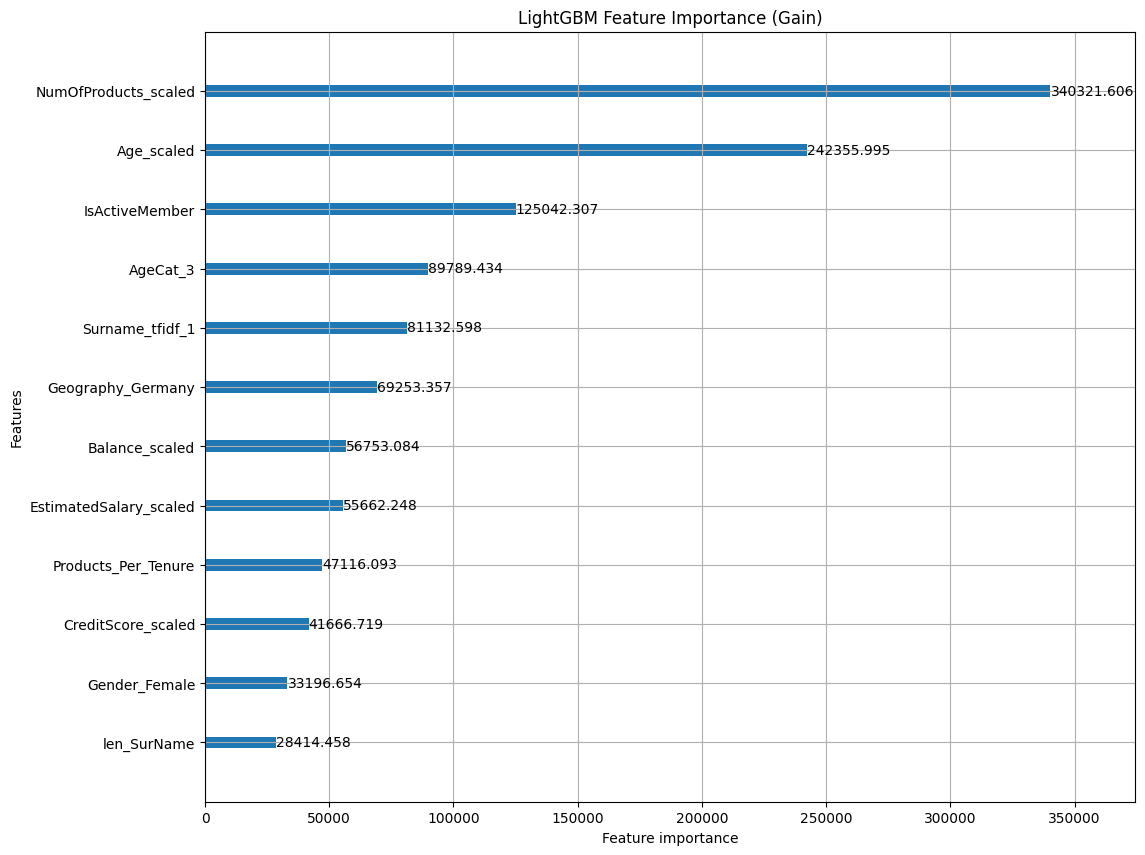

In [12]:
# Feature Importance
lgb_classifier = lgb.LGBMClassifier(**lgb_params)
lgb_classifier.fit(X, y)

lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(12, 10), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

In [13]:
# Training
folds = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    lgb_classifier = lgb.LGBMClassifier(**lgb_params)
    lgb_classifier.fit(X_train, y_train,
                       eval_set=[(X_val, y_val)],
                       eval_metric='auc',
                       early_stopping_rounds=100, verbose=200)

    y_pred_val = lgb_classifier.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print(f"AUC for fold {n_fold}: {auc_val}")
    auc_vals.append(auc_val)

    y_pred_test = lgb_classifier.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

[200]	valid_0's auc: 0.880234	valid_0's binary_logloss: 0.339808
[400]	valid_0's auc: 0.887553	valid_0's binary_logloss: 0.323088
[600]	valid_0's auc: 0.890828	valid_0's binary_logloss: 0.317468
[800]	valid_0's auc: 0.892376	valid_0's binary_logloss: 0.314883
[1000]	valid_0's auc: 0.89303	valid_0's binary_logloss: 0.31381
[1200]	valid_0's auc: 0.893464	valid_0's binary_logloss: 0.313045
[1400]	valid_0's auc: 0.893665	valid_0's binary_logloss: 0.312652
[1600]	valid_0's auc: 0.893741	valid_0's binary_logloss: 0.312426
AUC for fold 0: 0.8937836847692855
----------------
[200]	valid_0's auc: 0.877788	valid_0's binary_logloss: 0.341336
[400]	valid_0's auc: 0.885466	valid_0's binary_logloss: 0.325091
[600]	valid_0's auc: 0.889382	valid_0's binary_logloss: 0.319169
[800]	valid_0's auc: 0.891243	valid_0's binary_logloss: 0.316538
[1000]	valid_0's auc: 0.892096	valid_0's binary_logloss: 0.315389
[1200]	valid_0's auc: 0.892744	valid_0's binary_logloss: 0.314568
[1400]	valid_0's auc: 0.893182	val

In [14]:
# Evaluation
print("Mean AUC:", np.mean(auc_vals))


Mean AUC: 0.8947420266196664


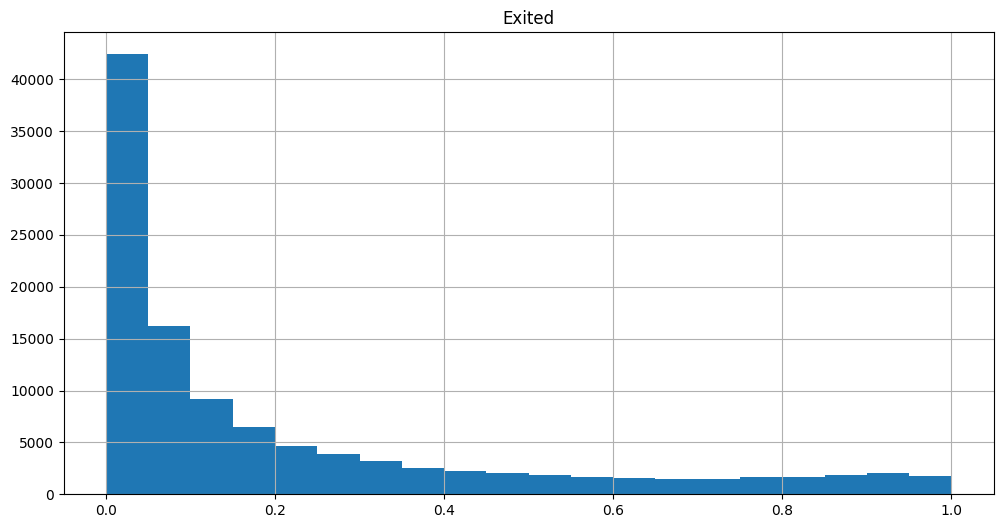

In [15]:
# Prediction and Submission
y_pred = test_preds.mean(axis=0)

df_orig = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
join_cols = list(df_orig.columns.drop(['RowNumber', 'Exited']))
df_orig.rename(columns={'Exited': 'Exited_Orig'}, inplace=True)
df_orig['Exited_Orig'] = df_orig['Exited_Orig'].map({0: 1, 1: 0})
df_test_ov = df_test_ov.merge(df_orig, on=join_cols, how='left')[['id', 'Exited_Orig']].fillna(-1)

df_sub = df_test_ov[['id', 'Exited_Orig']]

if USE_DATA_LEAK == 'Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig == -1, y_pred, df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred

df_sub.drop('Exited_Orig', axis=1, inplace=True)
df_sub.head()

df_sub.to_csv("submission.csv", index=False)

df_sub.hist(column='Exited', bins=20, range=[0, 1], figsize=(12, 6))
plt.show()